In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm 
from scipy.stats import lognorm

import gym
from stable_baselines3 import PPO
from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator

$x_i(x_{i-1}, y, \Delta t) = a+be^{-c\Delta t}+d-e(y-y_0)^2$ should satisfy the following conditions:   
$x_i = x_{i-1} \mbox{ when } \Delta t=0, y=0 \rightarrow a+b=x_{i-1}$    
$x_i = a+be^{-c\Delta t} \mbox{ when } y=0 \rightarrow d=e{y_0}^2$
Therefore, $x_i(x_{i-1}, y, \Delta t)$ can be expressed as $x_{i-1}-b+be^{-c\Delta t}+e(2yy_0-y^2)$ where we have four parameters: $b, c, e, y_0$           
$b$ is the asymptotic change of $x$ without any treatment, higher $b$ means larger change     
$c$ is the decrease rate of $x$, higher $c$ means higher rate        
$e$ is the sensitivity of $x$ to the dosage, higher $e$ means more sensitive     
$y_0$ is the optimal dosage

In [2]:
def xfunc(x, delta_t=2, y=5, b=10, c=0.5, e=3, y0=2):
    '''
    Input
    x: last obs/state
    delta_t: time interval btw visits
    y: dosage
    b, c, e, y0: parameters
    Output
    current obs/state
    '''
    return(x-b+b*np.exp(-c*delta_t)+e*(2*y*y0-y**2))   

In [3]:
y=np.arange(0, 6, 0.1)
delta_t=np.arange(0, 10, 0.1)

Text(0.5, 1.0, '$x_{i-1}=15, b=10, c=0.5, e=3, y0=2$')

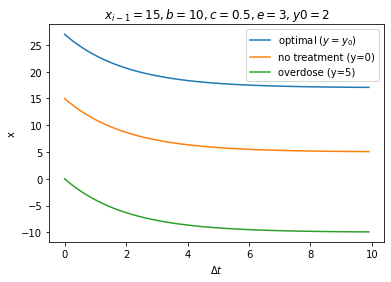

In [4]:
plt.figure()
plt.plot(delta_t, [xfunc(x=15, delta_t=delta_t_, y=2) for delta_t_ in np.arange(0, 10, 0.1)], label=r"optimal $(y=y_0)$")
plt.plot(delta_t, [xfunc(x=15, delta_t=delta_t_, y=0) for delta_t_ in np.arange(0, 10, 0.1)], label="no treatment (y=0)")
plt.plot(delta_t, [xfunc(x=15, delta_t=delta_t_, y=5) for delta_t_ in np.arange(0, 10, 0.1)], label="overdose (y=5)")
plt.legend()
plt.xlabel(r"$\Delta t$")
plt.ylabel("x")
plt.title(r"$x_{i-1}=15, b=10, c=0.5, e=3, y0=2$")

Text(0.5, 1.0, '$x_{i-1}=15, b=10, c=0.5, e=3, y0=2$')

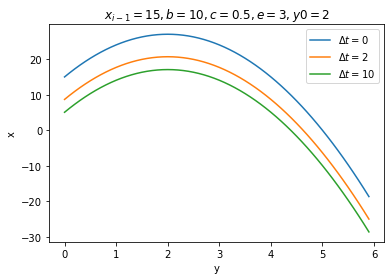

In [5]:
plt.figure()
plt.plot(y, [xfunc(x=15, y=y_, delta_t=0) for y_ in np.arange(0, 6, 0.1)], label=r"$\Delta t = 0$")
plt.plot(y, [xfunc(x=15, y=y_, delta_t=2) for y_ in np.arange(0, 6, 0.1)], label=r"$\Delta t = 2$")
plt.plot(y, [xfunc(x=15, y=y_, delta_t=10) for y_ in np.arange(0, 6, 0.1)], label=r"$\Delta t = 10$")
plt.legend()
plt.xlabel(r"y")
plt.ylabel("x")
plt.title(r"$x_{i-1}=15, b=10, c=0.5, e=3, y0=2$")

# Environment
The reward for every step is defined as the surviving days after last visit minus a penalty constant. If the patient did not make it to the next visit, the surviving days is the root of $x_i(\Delta t)=threshold$.     
Note: The root can be negative when the drift part ($e(2yy_0-y^2)$) is large (y deviates too far from $y_0$), but since one cannot live negative days, set surviving days to 0 in this condition.

In [7]:
class SimEnv(gym.Env):
    def __init__(self, b=10, c=0.5, e=3, y0=2, threshold=1, penalty=2, timeout=100):
        '''
        action_space: (y, delta_t)
        observation_space: (x)
        
        Input
        threshold: when x is lower than this threshold, patient die
        penalty: this parameter adds cost to frequent visits
        '''
        super(SimEnv, self).__init__()
        
        self.b = b
        self.c = c
        self.e = e
        self.y0 = y0
        self.threshold = threshold
        self.penalty = penalty
            
        self.action_space = gym.spaces.Box(low=0,high=float("inf"),shape=(2,),dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-float("inf"), high=float("inf"), shape=(1,), dtype=np.float32)
        self.state = None
        self.timeout = timeout
        self.steps_elapsed = 0
        
    def reset(self):
        self.state = np.random.uniform(self.threshold, 15, 1) # numpy array (1,)
        self.steps_elapsed=0
        return(self.state)
        
        
    def step(self, action):
        delta_t=action[1]
        y=action[0]
        next_obs = self.xfunc(x=self.state, delta_t=delta_t, y=action[0], b=self.b,c= self.c, e=self.e, y0=self.y0)
        
        if next_obs > self.threshold:
            reward = delta_t - self.penalty
        elif (-1/self.c*np.log((self.threshold-self.state+self.b-self.e*(2*y*self.y0-y**2))/self.b) < 0):
            reward = -self.penalty 
        else:
            reward = -1/self.c*np.log((self.threshold-self.state+self.b-self.e*(2*y*self.y0-y**2))/self.b) - self.penalty
            
        self.state = next_obs 
        self.steps_elapsed+=1
        
        return(np.array([self.state]).astype(np.float32), reward, next_obs <= self.threshold or self.steps_elapsed > self.timeout , {"x": self.state, "y": action[0], "delta_t": action[1], "dead": next_obs <= self.threshold})
    
    def xfunc(self, x, delta_t, y, b, c, e, y0):
        '''
        Input
        x: last obs/state
        delta_t: time interval btw visits
        y: dosage
        b, c, e, y0: parameters
        Output
        current obs/state
        '''
        return(x-b+b*np.exp(-c*delta_t)+e*(2*y*y0-y**2)) 
    
    def render(self, mode=None):
        pass
    def close(self):
        pass

In [8]:
S = SimEnv()
S.reset()

array([4.17613613])

# Random Trials without Policy Training

In [7]:
# random
r = [] #total reward for each episode
act = [] # every action taken in every episode
obs = []
env = SimEnv()

for i_episode in range(10):
    ep_reward = 0
    observation = env.reset()
    obs.append(observation)
    for t in range(100):
        action = env.action_space.sample() # shifted exponential
        observation, reward, done, info = env.step(action)
        #print("reward:", reward)
        ep_reward += reward
        act.append(action)
        obs.append(observation)
        
        if done or t == 99:
            print("Episode finished after {} timesteps".format(t+1))
            print("Survival time: {}".format(ep_reward+env.penalty*(t+1)))
            break
    r.append(ep_reward)

Episode finished after 100 timesteps
Survival time: 95.5695264339447
Episode finished after 100 timesteps
Survival time: 93.80322585909744
Episode finished after 100 timesteps
Survival time: 114.0510026793927
Episode finished after 100 timesteps
Survival time: 88.52081771079975
Episode finished after 100 timesteps
Survival time: 100.04398041963577
Episode finished after 100 timesteps
Survival time: 95.04264860088006
Episode finished after 100 timesteps
Survival time: 100.24064349383116
Episode finished after 1 timesteps
Survival time: 0
Episode finished after 100 timesteps
Survival time: 124.13089801417664
Episode finished after 3 timesteps
Survival time: 1.1140506863594055


Text(0.5, 0, 'time step (visit)')

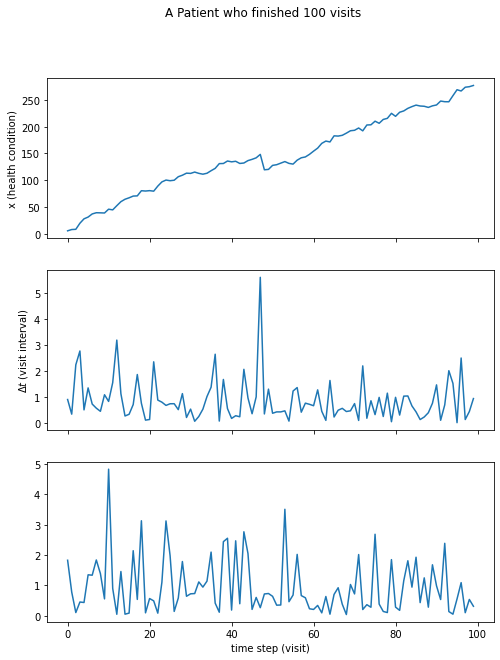

In [8]:
fig, axs = plt.subplots(3, sharex = True, figsize=[8,10])
fig.suptitle('A Patient who finished 100 visits')
axs[0].plot(obs[:100])
axs[1].plot([sub[0] for sub in act[:100]])
axs[2].plot([sub[1] for sub in act[:100]])

axs[0].set_ylabel("x (health condition)")
axs[1].set_ylabel("y (dosage)")
axs[1].set_ylabel(r"$\Delta t$ (visit interval)")
axs[2].set_xlabel("time step (visit)")

In [150]:
# fig, axs = plt.subplots(3, sharex = True, figsize=[8,10])
# fig.suptitle('A Patient who was dead before the 16th visits')
# axs[0].plot(obs[108:125])
# axs[1].plot([sub[0] for sub in act[108:125]])
# axs[2].plot([sub[1] for sub in act[108:125]])

# axs[0].set_ylabel("x (health condition)")
# axs[1].set_ylabel("y (dosage)")
# axs[1].set_ylabel(r"$\Delta t$ (visit interval)")
# axs[2].set_xlabel("time step (visit)")

# Policy - PPO

In [10]:
env=SimEnv()

In [138]:
#policy = PPO("MlpPolicy", env, n_steps=128, verbose=1, tensorboard_log ='smmResults/').learn(total_timesteps=10000)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Text(0.5, 1.0, 'Mean Episode Reward Over 5 Episodes')

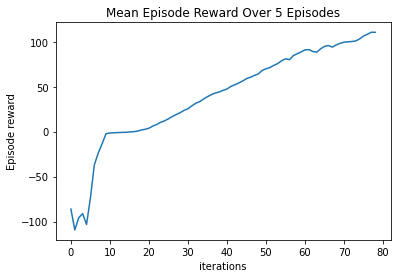

In [12]:
rewards = []
losses = []
for e in tf.compat.v1.train.summary_iterator('smmResults/PPO_9/PPO1'):
    for v in e.summary.value:
        if v.tag == "rollout/ep_rew_mean":
            rewards.append(v.simple_value)
        if v.tag == "train/loss":
            losses.append(v.simple_value)
plt.figure()
plt.plot(rewards)
plt.xlabel("iterations")
plt.ylabel("Episode reward")
plt.title("Mean Episode Reward Over 5 Episodes")

Text(0.5, 1.0, 'Mean Episode Length Over 5 Episodes')

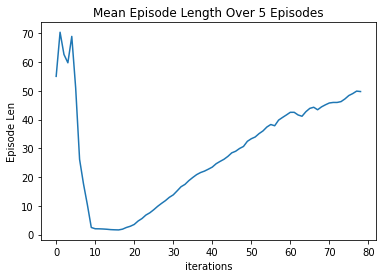

In [15]:
rewards = []
length = []
for e in tf.compat.v1.train.summary_iterator('smmResults/PPO_9/PPO1'):
    for v in e.summary.value:
        if v.tag == "rollout/ep_rew_mean":
            rewards.append(v.simple_value)
        if v.tag == "rollout/ep_len_mean":
            length.append(v.simple_value)
plt.figure()
plt.plot(length)
plt.xlabel("iterations")
plt.ylabel("Episode Len")
plt.title("Mean Episode Length Over 5 Episodes")

# Q actor critic
$b(t_{i,2}) = x_i$     
$Q(y_i, \Delta_i, b(t_{i,2})) = \phi_0+\phi_1*y_i+\phi_2*\Delta_i+\phi_3*b(t_{i,2})$    
$y_i \sim Normal(\theta_0+\theta_1x_i, 1)$       
$log(\Delta_i) \sim Normal(\theta_2+\theta_3x_i, 1)$

In [144]:
class QAC:
    def __init__(self, env):
        self.env = env
        self.obs_space = env.observation_space
        self.act_space = env.action_space
        self.theta = np.zeros(4)
        self.phi = np.zeros(4)
        self.obs = None # To do: b and x will need to be seperated
        self.total_obs = []
        self.total_act = []
        self.total_rew = []
        self.total_ep_rew=[]

    def act_sample(self):
        y = np.random.normal(self.theta[0]+self.theta[1]*self.obs[0], 1)
        delta = np.random.lognormal(self.theta[2]+self.theta[3]*self.obs[0], 1)+ 10**(-5)
        # To do: add more flexibility to distribution to sample from
        
        return(y, delta) # two numbers
    
    def Q(self, y, delta, obs):
        return((self.phi[0] + self.phi[1]*y + self.phi[2]*delta + self.phi[3]*obs[0])) # a number
    
    def train(self, total_steps, eta, gamma):
        self.obs = self.env.reset() # line4
        y, delta = self.act_sample() # line5
        for i in range(total_steps): # line6
            old_obs = self.obs
            self.obs, reward, done, __ = self.env.step([y, delta]) # line8, line9
            if done:
                break
            #line 7
#             print("y",y)
#             print("delta",delta)
#             print("phi", self.phi)
#             print("theta", self.theta)
#             print("Q", self.Q(y, delta, self.obs))
#             print("gradLogPdf02", self.gradientLOGPDF(y, self.theta[0:2]))
#             print("gradLogPdf24", self.gradientLOGPDF(delta, self.theta[2:],func=lognorm))
            self.theta[0:2] = self.theta[0:2] + eta*self.Q(y, delta, self.obs)*self.gradientLOGPDF(y, self.theta[0:2])
            self.theta[2:] = self.theta[2:] + eta*self.Q(y, delta, self.obs)*self.gradientLOGPDF(delta, self.theta[2:], func=lognorm)
            old_y, old_delta = y, delta
            y, delta = self.act_sample() # line10
            TD = reward + gamma*self.Q(y, delta, self.obs)-self.Q(old_y, old_delta, old_obs) # line11
#            print("gradQ", self.gradientQ(old_y, old_delta, old_obs))
            self.phi = self.phi + eta*TD*self.gradientQ(old_y, old_delta, old_obs) #line12
            
    def gradientQ(self, y, delta, obs, eps=10**(-5)):
        dphi0 = ((self.phi[0]+eps + self.phi[1]*y + self.phi[2]*delta + self.phi[3]*obs[0])-
                 self.Q(y, delta, obs))/eps
        dphi1 = ((self.phi[0] + (self.phi[1]+eps)*y + self.phi[2]*delta + self.phi[3]*obs[0])-
                 self.Q(y, delta, obs))/eps
        dphi2 = ((self.phi[0] + self.phi[1]*y + (self.phi[2]+eps)*delta + self.phi[3]*obs[0])-
                 self.Q(y, delta, obs))/eps
        dphi3 = ((self.phi[0] + self.phi[1]*y + self.phi[2]*delta + (self.phi[3]+eps)*obs[0])-
                 self.Q(y, delta, obs))/eps
        return(np.array([dphi0, dphi1, dphi2, dphi3])) # shape prob
            
            
    def gradientLOGPDF(self, x, param, func=norm, eps=10**(-5)): # param: np.array(2,)
        if func == norm:
            dparam0 = (func.logpdf(x, (param[0]+eps)+param[1]*self.obs[0], 1) - 
                       func.logpdf(x, param[0]+param[1]*self.obs[0] ,1))/eps# forward finite
            dparam1 = (func.logpdf(x, param[0]+(param[1]+eps)*self.obs[0], 1) - 
                       func.logpdf(x, param[0]+param[1]*self.obs[0] ,1))/eps# forward finite
        elif func == lognorm:
            dparam0 = (func.logpdf(x=x, loc=0, scale=np.exp((param[0]+eps)+param[1]*self.obs[0]), s=1)- 
                       func.logpdf(x=x, loc=0, scale=np.exp(param[0]+param[1]*self.obs[0]) ,s=1))/eps# forward finite
            dparam1 = (func.logpdf(x=x, loc=0,scale=np.exp(param[0]+(param[1]+eps)*self.obs[0]), s=1) - 
                       func.logpdf(x=x,loc=0, scale=np.exp(param[0]+param[1]*self.obs[0]) ,s=1))/eps# forward finite


            
        return(np.array([dparam0, dparam1])) # shape prob
    
    def eval(self, n_ep=5, timeout=100):
        for i_episode in range(n_ep):
            obs = []
            act = []
            rew = []
            ep_reward_ls = []
            ep_reward = 0
            observation = self.env.reset()
            obs.append(observation)
            for t in range(timeout):
                action = self.act_sample()
                observation, reward, done, info = self.env.step(action)
                #print("reward:", reward)
                ep_reward += reward
                rew.append(reward)
                act.append(action)
                obs.append(observation)

                if done or t == 99:
                    #print("Episode finished after {} timesteps".format(t+1))
                    #print("Survival time: {}".format(ep_reward+env.penalty*(t+1)))
                    break
            ep_reward_ls.append(ep_reward)       
            self.total_rew.append(rew)
            self.total_act.append(act)
            self.total_obs.append(obs)
            
        self.total_ep_rew.append(np.mean(ep_reward))
            
    def learn(self, total_timesteps, eta, gamma, n_ep=5, timeout=100):
        #evaluate every 100 policy updates
        for i in tqdm(range(total_timesteps//100)):
            #print("----------Start Training Iteration {}----------".format(i))
            self.train(total_steps=100, eta=eta, gamma=gamma)
            #print("----------End Training Iteration {}----------".format(i))
            #print("----------Start Evaluating Iteration {}----------".format(i))
            self.eval()
            #print("----------End Evaluating Iteration {}----------".format(i))
    
    def clear():
        self.total_obs = []
        self.total_act = []
        self.total_rew = []
        self.total_ep_rew=[]

In [145]:
policy = QAC(env)
policy.learn(total_timesteps=1000000, eta=0.001, gamma=0.9)

100%|██████████| 10000/10000 [00:03<00:00, 2850.74it/s]


Text(0.5, 1.0, '100 policy updates at most per iteration,')

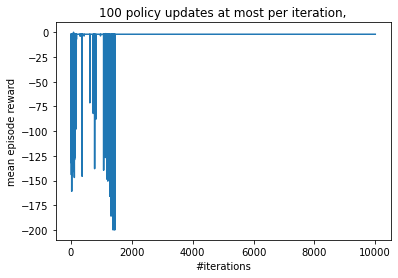

In [148]:
plt.figure()
plt.plot(policy.total_ep_rew)
plt.xlabel("#iterations")
plt.ylabel("mean episode reward")
plt.title("100 policy updates at most per iteration,")

In [151]:
policy.total_act[-1000]

[(5.214541409479014e+22, inf)]

In [11]:
env=SimEnv()
env.action_space.sample()
env.reset()

array([9.18541608])